In [1]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


torch.Size([3, 128, 128])


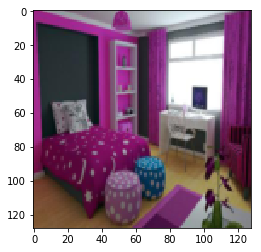

128 1024


In [2]:
if not os.path.exists('./previews'):
    os.makedirs('./previews')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
n_dim = 128
n_feature = 1024
n_ch = 3
g_feature_map_b = 64
d_feature_map_b = 64

fold_dataset = datasets.ImageFolder('./data0/lsun/bedroom', 
                       transform=transforms.Compose([
                           transforms.Resize([n_dim]*2, interpolation=2),
                           transforms.ToTensor(), # normalize to [0,1]
                           transforms.Normalize([0.5]*n_ch, [0.5]*n_ch) # [0,1] -> [-1,+1]
                       ]))
'''
fold_dataset = datasets.MNIST('./mnist_data', download=True, train=False, transform=transforms.Compose([
                           transforms.Pad(2), # 28 -> 32
                           transforms.ToTensor(), # normalize to [0,1]
                           transforms.Normalize([0.5]*n_ch, [0.5]*n_ch) # [0,1] -> [-1,+1]
                       ]))
'''
print(fold_dataset.__getitem__(100)[0].shape)
plt.imshow(np.squeeze(np.clip(np.array(fold_dataset.__getitem__(100)[0]).transpose(1,2,0)*127.5+127.5,0,255).astype(np.uint8)))
plt.show()
data_loader = torch.utils.data.DataLoader(
        fold_dataset,
        batch_size=batch_size, shuffle=True, num_workers=4)
print(n_dim, n_feature)
def inf_data_gen():
    while True:
        for data, label in data_loader:
            yield data, label
gen = inf_data_gen()

In [3]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

def gradient_penalty_loss(C, real, fake, lambda_, device):
    w = torch.rand(real.size(0), 1, 1, 1, device=device).expand_as(real)
    x_hat = w*real + (1-w)*fake
    x_hat_g = torch.autograd.Variable(x_hat, requires_grad=True)
    D_x_hat_g = C(x_hat_g)
    gradients = torch.autograd.grad(outputs=D_x_hat_g, inputs=x_hat_g,
                              grad_outputs=torch.ones_like(D_x_hat_g, device=device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_
    return gradient_penalty

class C(nn.Module):
    def __init__(self, N_DIM, N_CH, BASE_FEATURE_N=32):
        super(C, self).__init__()
        self.n_dim = N_DIM
        self.n_ch  = N_CH
        self.base_f = BASE_FEATURE_N
        self.lrelu = nn.LeakyReLU(0.2)
        self.conv_head = nn.Conv2d(self.n_ch, self.base_f, 3, stride=1, padding=1, bias=False) 
        self.conv1 = nn.Conv2d(self.base_f, self.base_f, 3, stride=2, padding=1, bias=False) 
        self.conv2 = nn.Conv2d(self.base_f, self.base_f*2, 3, stride=2, padding=1, bias=False) 
        self.in2   = nn.InstanceNorm2d(self.base_f*2)
        self.conv2_1 = nn.Conv2d(self.base_f*2, self.base_f*2, 3, stride=1, padding=1, bias=False) 
        self.in2_1   = nn.InstanceNorm2d(self.base_f*2)
        self.conv3 = nn.Conv2d(self.base_f*2, self.base_f*4, 3, stride=2, padding=1, bias=False) 
        self.in3   = nn.InstanceNorm2d(self.base_f*4)
        self.conv3_1 = nn.Conv2d(self.base_f*4, self.base_f*4, 3, stride=1, padding=1, bias=False) 
        self.in3_1   = nn.InstanceNorm2d(self.base_f*4)
        self.conv4 = nn.Conv2d(self.base_f*4, self.base_f*8, 3, stride=2, padding=1, bias=False) 
        self.in4   = nn.InstanceNorm2d(self.base_f*8)
        self.fc1   = nn.Conv2d(self.base_f*8, 1, self.n_dim//16, stride=1, padding=0, bias=False)
    def forward(self, x):
        
        x = self.conv_head(x) 
        x = self.lrelu(x)
        x = self.conv1(x) 
        x = self.lrelu(x)
        
        x = self.conv2(x) 
        x = self.in2(x) 
        x = self.lrelu(x)
        x = self.conv2_1(x) 
        x = self.in2_1(x) 
        x = self.lrelu(x)
        
        x = self.conv3(x) 
        x = self.in3(x)
        x = self.lrelu(x)
        x = self.conv3_1(x) 
        x = self.in3_1(x)
        x = self.lrelu(x)
        
        x = self.conv4(x) 
        x = self.in4(x)
        x = self.lrelu(x)
        
        x = self.fc1(x) 
        x = x.view(x.size(0), 1) 
        return x

class G(nn.Module):
    def __init__(self, N_DIM, N_FEATURE, N_CH, BASE_FEATURE_N=32):
        super(G, self).__init__()
        self.n_dim = N_DIM
        self.n_ch  = N_CH
        self.base_f = BASE_FEATURE_N
        self.n_feature = N_FEATURE
        self.conv_head = nn.Conv2d((self.n_feature)//((self.n_dim//16)**2), self.base_f*8, 3, stride=1, padding=1, bias=False) 
        self.up1   = nn.PixelShuffle(2)
        self.conv1 = nn.Conv2d(self.base_f*2, self.base_f*4, 3, stride=1, padding=1, bias=False) 
        self.in1   = nn.InstanceNorm2d(self.base_f*4)
        self.conv1_1 = nn.Conv2d(self.base_f*4, self.base_f*4, 3, stride=1, padding=1, bias=False) 
        self.in1_1   = nn.InstanceNorm2d(self.base_f*4)
        self.up2   = nn.PixelShuffle(2)
        self.conv2 = nn.Conv2d(self.base_f, self.base_f*2, 3, stride=1, padding=1, bias=False) 
        self.in2   = nn.InstanceNorm2d(self.base_f*2)
        self.conv2_1 = nn.Conv2d(self.base_f*2, self.base_f*2, 3, stride=1, padding=1, bias=False) 
        self.in2_1   = nn.InstanceNorm2d(self.base_f*2)
        self.up3   = nn.PixelShuffle(2)
        self.conv3 = nn.Conv2d(self.base_f//2, self.base_f, 3, stride=1, padding=1, bias=False) 
        self.in3   = nn.InstanceNorm2d(self.base_f)
        self.conv3_1 = nn.Conv2d(self.base_f, self.base_f, 3, stride=1, padding=1, bias=False) 
        self.in3_1   = nn.InstanceNorm2d(self.base_f)
        self.up4   = nn.PixelShuffle(2)
        self.conv4 = nn.Conv2d(self.base_f//4, self.n_ch, 3, stride=1, padding=1, bias=False) 
    def forward(self, x):
        x = x.view(x.size(0), x.size(1)//((self.n_dim//16)**2), (self.n_dim//16), (self.n_dim//16)) 
        
        x = self.conv_head(x)
        x = self.up1(x)
        x = self.conv1(x) 
        x = self.in1(x) 
        x = F.relu(x)
        s = x
        x = self.conv1_1(x) 
        x = x + s
        x = self.in1_1(x) 
        x = F.relu(x)
        
        x = self.up2(x)
        x = self.conv2(x)  
        x = self.in2(x)
        x = F.relu(x)
        s = x
        x = self.conv2_1(x)  
        x = x + s
        x = self.in2_1(x)
        x = F.relu(x)
        
        x = self.up3(x)
        x = self.conv3(x)  
        x = self.in3(x)
        x = F.relu(x)
        x = self.conv3_1(x) 
        x = self.in3_1(x)
        x = F.relu(x)
        
        x = self.up4(x)
        x = self.conv4(x)  
        x = torch.tanh(x)
        return x

def D(C, r, f):
    return C(r) - C(f).mean()

In [4]:
def plot2dir(directory='./previews', imgs=None, iter_n=0):
    imgs = np.clip(np.round((np.concatenate(tuple(imgs.transpose(0,2,3,1)), axis=0)+1)*127.5), 0, 255).astype(np.uint8) # (?, 28, 28)
    cv2.imwrite('{}/{:08d}.jpg'.format(directory, iter_n), np.squeeze(imgs[...,::-1])) # RGB->BGR
    

In [ ]:
seed = 31 # debug!!!
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
G_net = G(n_dim, n_feature, n_ch, g_feature_map_b).to(device).apply(weights_init)
C_net = C(n_dim, n_ch, d_feature_map_b).to(device).apply(weights_init)
opt_C = optim.Adam(C_net.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_G = optim.Adam(G_net.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
from tqdm import tqdm_notebook

iterations = 10000
preview_iter = 200
# max_preview_imgs = 5
d_iter = 1
std = 0.2
lambda_1 , lambda_2 = 10 , 0.2
M = 0.05

for ite in tqdm_notebook(range(1, iterations+1)):
    start_train_ts = time.time()
    # train D:
    G_net.eval()
    C_net.train()
    d_loss_mean = 0.0
    g_loss_mean = 0.0
    for _ in range(d_iter):
        opt_C.zero_grad()
        real = next(gen)[0]
        real = real.to(device)
        sample = torch.randn(real.size(0), n_feature, device=device).clamp(-2,2) * std
        fake   = G_net(sample).detach() # not to touch G_net
        d_loss_real = ((D(C_net,real,fake) - 1)**2).mean()
        d_loss_real.backward() # train with real
        d_loss_fake = ((D(C_net,fake,real) + 1)**2).mean()
        d_loss_fake.backward() # train with fake
        d_loss = d_loss_real + d_loss_fake
        opt_C.step()
        d_loss_mean += d_loss.item()
    d_loss_mean /= d_iter
    D_update_ts = time.time()
    # train G:
    real = next(gen)[0]
    real = real.to(device)
    G_net.train()
    C_net.eval()
    opt_G.zero_grad()
    sample = torch.randn(real.size(0), n_feature, device=device).clamp(-2,2) * std
    generated = G_net(sample)
    g_loss = ((D(C_net,generated,real) - 1)**2).mean() + ((D(C_net,real,generated) + 1)**2).mean()
    g_loss.backward()
    opt_G.step()
    g_loss_mean = g_loss.mean().item()
    G_update_ts = time.time()
    if ite%preview_iter==0:
        print('[{}/{}] G: {:.4f}, D:{:.4f} -- elapsed_G: {:.4f}s -- elapsed_D: {:.4f}s'.format(ite, iterations, g_loss_mean, d_loss_mean, (G_update_ts-D_update_ts), (D_update_ts-start_train_ts) ))
        plot2dir('./previews', generated[:8].detach().cpu().numpy(), ite)

[200/10000] G: 8.6785, D:10.9910 -- elapsed_G: 0.2009s -- elapsed_D: 0.1802s
[400/10000] G: 8.7866, D:0.9762 -- elapsed_G: 0.2004s -- elapsed_D: 0.1823s
[600/10000] G: 8.3502, D:0.5801 -- elapsed_G: 0.2020s -- elapsed_D: 0.1812s
[800/10000] G: 5.8516, D:0.5713 -- elapsed_G: 0.2016s -- elapsed_D: 0.1826s
